In [1]:
import numpy as np
from cmaes import CMA
# import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColorBar, LinearColorMapper
from bokeh.io import push_notebook
import itertools
import matplotlib.pyplot as plt
import time

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="Single-shot")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 198kB
Dimensions:  (dim_0: 2744)
Coordinates:
    x0       (dim_0) float64 22kB 4.8e-08 1.04e-07 1.64e-07 ... 7.4e-07 7.96e-07
    x1       (dim_0) float64 22kB 7.37e+09 7.37e+09 ... 7.42e+09 7.42e+09
    x2       (dim_0) float64 22kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 22kB 0.5118 0.5128 0.5101 ... 0.7327 0.7516 0.5369
    y1       (dim_0) float64 22kB 0.511 0.5122 0.5066 ... 0.777 0.8044 0.5442
    y2       (dim_0) float64 22kB 0.5126 0.5181 0.5101 ... 0.8332 0.8606 0.5499
    y3       (dim_0) float64 22kB 0.5119 0.5083 0.5136 ... 0.588 0.5898 0.5166
    y4       (dim_0) float64 22kB 0.5 0.5063 0.5 0.503 ... 0.6812 0.7066 0.6645
    y5       (dim_0) float64 22kB 0.5039 0.5016 0.5063 0.5 ... 0.637 0.6667 0.5
Attributes:
    tuid:                             20241207-194048-547-5c7816
    name:                             Single-shot readout vs. pulse duration,...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [4]:
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data

unique_durations = np.unique(duration)
# print(len(unique_durations))
# print(unique_durations)
# print(np.diff(unique_durations))

indices = np.where(duration == unique_durations[-1])
frequency = frequency[indices]
amplitude = amplitude[indices]
fidelity = average_fidelity[indices]

In [5]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data

#Extract data for a single unique duration
unique_durations = np.unique(duration)
indices = np.where(duration == unique_durations[-1])
frequency = frequency[indices]
amplitude = amplitude[indices]
fidelity = average_fidelity[indices]

#Plot data with Bokeh:

# Ensure Bokeh outputs to the notebook
# This allows the Bokeh plot to be rendered directly in the Jupyter Notebook.
output_notebook()

# Reshape fidelity to 2D (if not already a grid)
# Assume 'fidelity' is a 1D array and needs to be reshaped into a 2D grid for plotting.
# Use the square root of the array's length to determine the grid dimensions.
Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

# Calculate the extent of the axes for imshow-like behavior
# This determines the range of the x and y axes based on frequency and amplitude values.
dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along the x-axis
dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along the y-axis

# Define the extent, which specifies the range of the axes
extent = [
    frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
    amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
]

# Set up a color mapper to map fidelity values to colors
# 'Viridis256' is a built-in colormap with 256 shades.
cmap = 'Viridis256'  # Colormap for the plot
vmin, vmax = 0.5, 1  # Set the range of fidelity values for color mapping
color_mapper = LinearColorMapper(palette=cmap, low=vmin, high=vmax)

# Create the figure for the plot
# Customize the title, axis labels, range, and size of the figure.
p = figure(
    title="test",  # Title of the plot
    x_range=(extent[0], extent[1]),  # Range for the x-axis (frequency)
    y_range=(extent[2], extent[3]),  # Range for the y-axis (amplitude)
    x_axis_label="Frequency [Hz]",  # Label for the x-axis
    y_axis_label="Amplitude [V]",   # Label for the y-axis
    tooltips=[("Fidelity", "@image")],  # Tooltip to display fidelity values on hover
    width=800,  # Width of the figure in pixels
    height=600  # Height of the figure in pixels
)

# Add the 2D image (heatmap) to the figure
# The 'image' glyph plots the 2D array 'Z' as a heatmap on the specified range.
p.image(
    image=[Z],              # The 2D array to plot (fidelity values)
    x=extent[0],            # Start position of the image along the x-axis
    y=extent[2],            # Start position of the image along the y-axis
    dw=extent[1] - extent[0],  # Width of the image (frequency range)
    dh=extent[3] - extent[2],  # Height of the image (amplitude range)
    color_mapper=color_mapper  # Use the color mapper for fidelity values
)

# Add a color bar to the figure
# The color bar provides a visual representation of the fidelity value range.
color_bar = ColorBar(
    color_mapper=color_mapper,  # The color mapper used for the image
    label_standoff=12,          # Distance between the color bar and its label
    title="Fidelity",           # Title of the color bar
    border_line_color=None,     # Remove border around the color bar
    location=(0, 0)             # Position of the color bar
)
p.add_layout(color_bar, 'right')  # Add the color bar to the right of the plot

# Render the plot in the notebook
# The 'notebook_handle=True' allows for interactive updates if needed.
show(p, notebook_handle=True)


Loading BokehJS ...

In [6]:
def fidelityEstimate3D(point, frequency, amplitude, duration, fidelity):
    # Get unique values of frequency, amplitude, and duration
    unique_freq = np.unique(frequency)
    unique_ampl = np.unique(amplitude)
    unique_dur = np.unique(duration)
    
    # Get the closest 3 unique frequencies, amplitudes, and durations
    dFreq = np.abs(unique_freq - point[0])
    dAmpl = np.abs(unique_ampl - point[1])
    dDur = np.abs(unique_dur - point[2])
    
    freqArgs = np.argsort(dFreq)[:2]
    amplArgs = np.argsort(dAmpl)[:2]
    durArgs = np.argsort(dDur)[:2]
    
    x_coor = unique_freq[freqArgs]
    y_coor = unique_ampl[amplArgs]
    z_coor = unique_dur[durArgs]
    
    # Sort the coordinates
    sortedX = np.sort(x_coor)
    sortedY = np.sort(y_coor)
    sortedZ = np.sort(z_coor)
    
    # Calculate differences
    dx = np.diff(sortedX)
    dy = np.diff(sortedY)
    dz = np.diff(sortedZ)
    
    fidelities = []
    
    # Iterate through all combinations of (frequency, amplitude, duration)
    for i in itertools.product(sortedX, sortedY, sortedZ):
        temp1 = np.where(i[0] == frequency)
        temp2 = np.where(i[1] == amplitude)
        temp3 = np.where(i[2] == duration)
        arg = np.intersect1d(np.intersect1d(temp1, temp2), temp3)
        fidelities.append(fidelity[arg])
    
    fidelities = np.array(fidelities)
    
    # Reshape fidelities into a 2x2x2 grid for interpolation
    fidelity_matrix = fidelities.reshape((2, 2, 2))
    
    # 3D Bilinear interpolation formula
    result = (fidelity_matrix[0, 0, 0] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[1, 0, 0] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[0, 1, 0] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[1, 1, 0] * (point[0] - sortedX[0]) * (point[1] - sortedY[0]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[0, 0, 1] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[1, 0, 1] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[0, 1, 1] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[1, 1, 1] * (point[0] - sortedX[0]) * (point[1] - sortedY[0]) * (point[2] - sortedZ[0])) / (dx * dy * dz)
    
    return result

In [7]:
def objective(points, frequency, amplitude, duration, fidelity):
    objective = np.zeros(len(points))
    for i in range(len(points)):
        F = fidelityEstimate3D(points[i], frequency, amplitude, duration, fidelity)
        objective[i] = np.log(1-F)[0]
    return objective
    
def cmaes_frequency_amplitude_and_duration(mean, sigma, popsize, Ngen, meas_freq, meas_ampl, meas_dur, meas_fid):
    boundX = [0, 1]
    boundY = [0, 1]
    boundZ = [0, 1]

    minFreq = np.min(meas_freq)
    maxFreq = np.max(meas_freq)

    minAmpl = np.min(meas_ampl)
    maxAmpl = np.max(meas_ampl)

    minDur = np.min(meas_dur)
    maxDur = np.max(meas_dur)
    
    bounds = np.array([boundX, boundY, boundZ])
    
    optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)

    deltaFreq = maxFreq - minFreq
    deltaAmpl = maxAmpl - minAmpl
    deltaDur = maxDur- minDur

    # coordinate = np.zeros((Ngen, 3))
    fidelity_mean = np.zeros(Ngen)

    for generation in range(Ngen):  
        normalized_mean = optimizer.mean
    
        mean = np.copy(normalized_mean)
        
        mean[0] = mean[0] * deltaFreq + minFreq
        mean[1] = mean[1] * deltaAmpl + minAmpl
        mean[2] = mean[2] * deltaDur + minDur

        fidelity_mean[generation] = fidelityEstimate3D(mean, meas_freq, meas_ampl, meas_dur, meas_fid)[0]
    
        normalized_freq = np.zeros(popsize)
        normalized_ampl = np.zeros(popsize)
        normalized_dur = np.zeros(popsize)
        
        frequencies = np.zeros(popsize)
        amplitudes = np.zeros(popsize)
        durations = np.zeros(popsize)
        
        for i in range(popsize):
            x = optimizer.ask()
            
            normalized_freq[i] = x[0]
            normalized_ampl[i] = x[1]
            normalized_dur[i] = x[2]

            frequencies[i] = x[0]*deltaFreq + minFreq
            amplitudes[i] = x[1]*deltaAmpl + minAmpl
            durations[i] = x[2]*deltaDur + minDur
                    
        normalized_freq_ampl_and_dur = [(float(xi), float(yi), float(zi)) for xi, yi, zi in zip(normalized_freq, normalized_ampl, normalized_dur)]
        freq_ampl_and_dur = np.array([np.array([xi, yi, zi]) for xi, yi, zi in zip(frequencies, amplitudes, durations)])
        objective_value = objective(freq_ampl_and_dur, meas_freq, meas_ampl, meas_dur, meas_fid)

        solutions = [(wi, float(vi)) for wi, vi in zip(normalized_freq_ampl_and_dur, objective_value)]
        optimizer.tell(solutions)

    # fidelity = fidelityEstimate3D(mean, meas_freq, meas_ampl, meas_dur, meas_fid)[0]
    return fidelity_mean

In [8]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data

popsize = 10
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0,0.0])
Ngen = 2
Nreal = 1


fidelity_evolution = np.zeros((Nreal,Ngen))

for i in range(Nreal):
    fidelity_evolution[i,:] = cmaes_frequency_amplitude_and_duration(mean, sigma, popsize, Ngen, frequency, amplitude, duration, QND_pi_fidelity)
    
mean_fidelity_evolution = np.mean(fidelity_evolution,axis=0)
std_fidelity_evolution = np.std(fidelity_evolution,axis=0)

print(mean_fidelity_evolution)

[0.50392673 0.83177874]


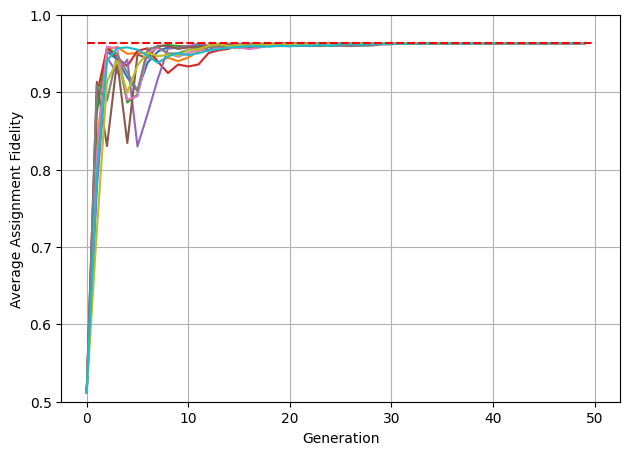

In [9]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data

popsize = 10
sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0,0.0])
Ngen = 50
Nreal = 10


fidelity_evolution = np.zeros((Nreal,Ngen))

for i in range(Nreal):
    fidelity_evolution[i,:] = cmaes_frequency_amplitude_and_duration(mean, sigma, popsize, Ngen, frequency, amplitude, duration, average_fidelity)
    
mean_fidelity_evolution = np.mean(fidelity_evolution,axis=0)
std_fidelity_evolution = np.std(fidelity_evolution,axis=0)

for i in range(Nreal):
    # print(len(fidelity_evolution[i,:]))
    plt.plot(range(Ngen),fidelity_evolution[i,:])

plt.xlabel("Generation")
plt.ylabel("Average Assignment Fidelity")
plt.ylim([0.5, 1])
plt.hlines(max(average_fidelity), 0, Ngen, color='red', linestyle="--", label="Max Avg Fidelity")
plt.grid()
# ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


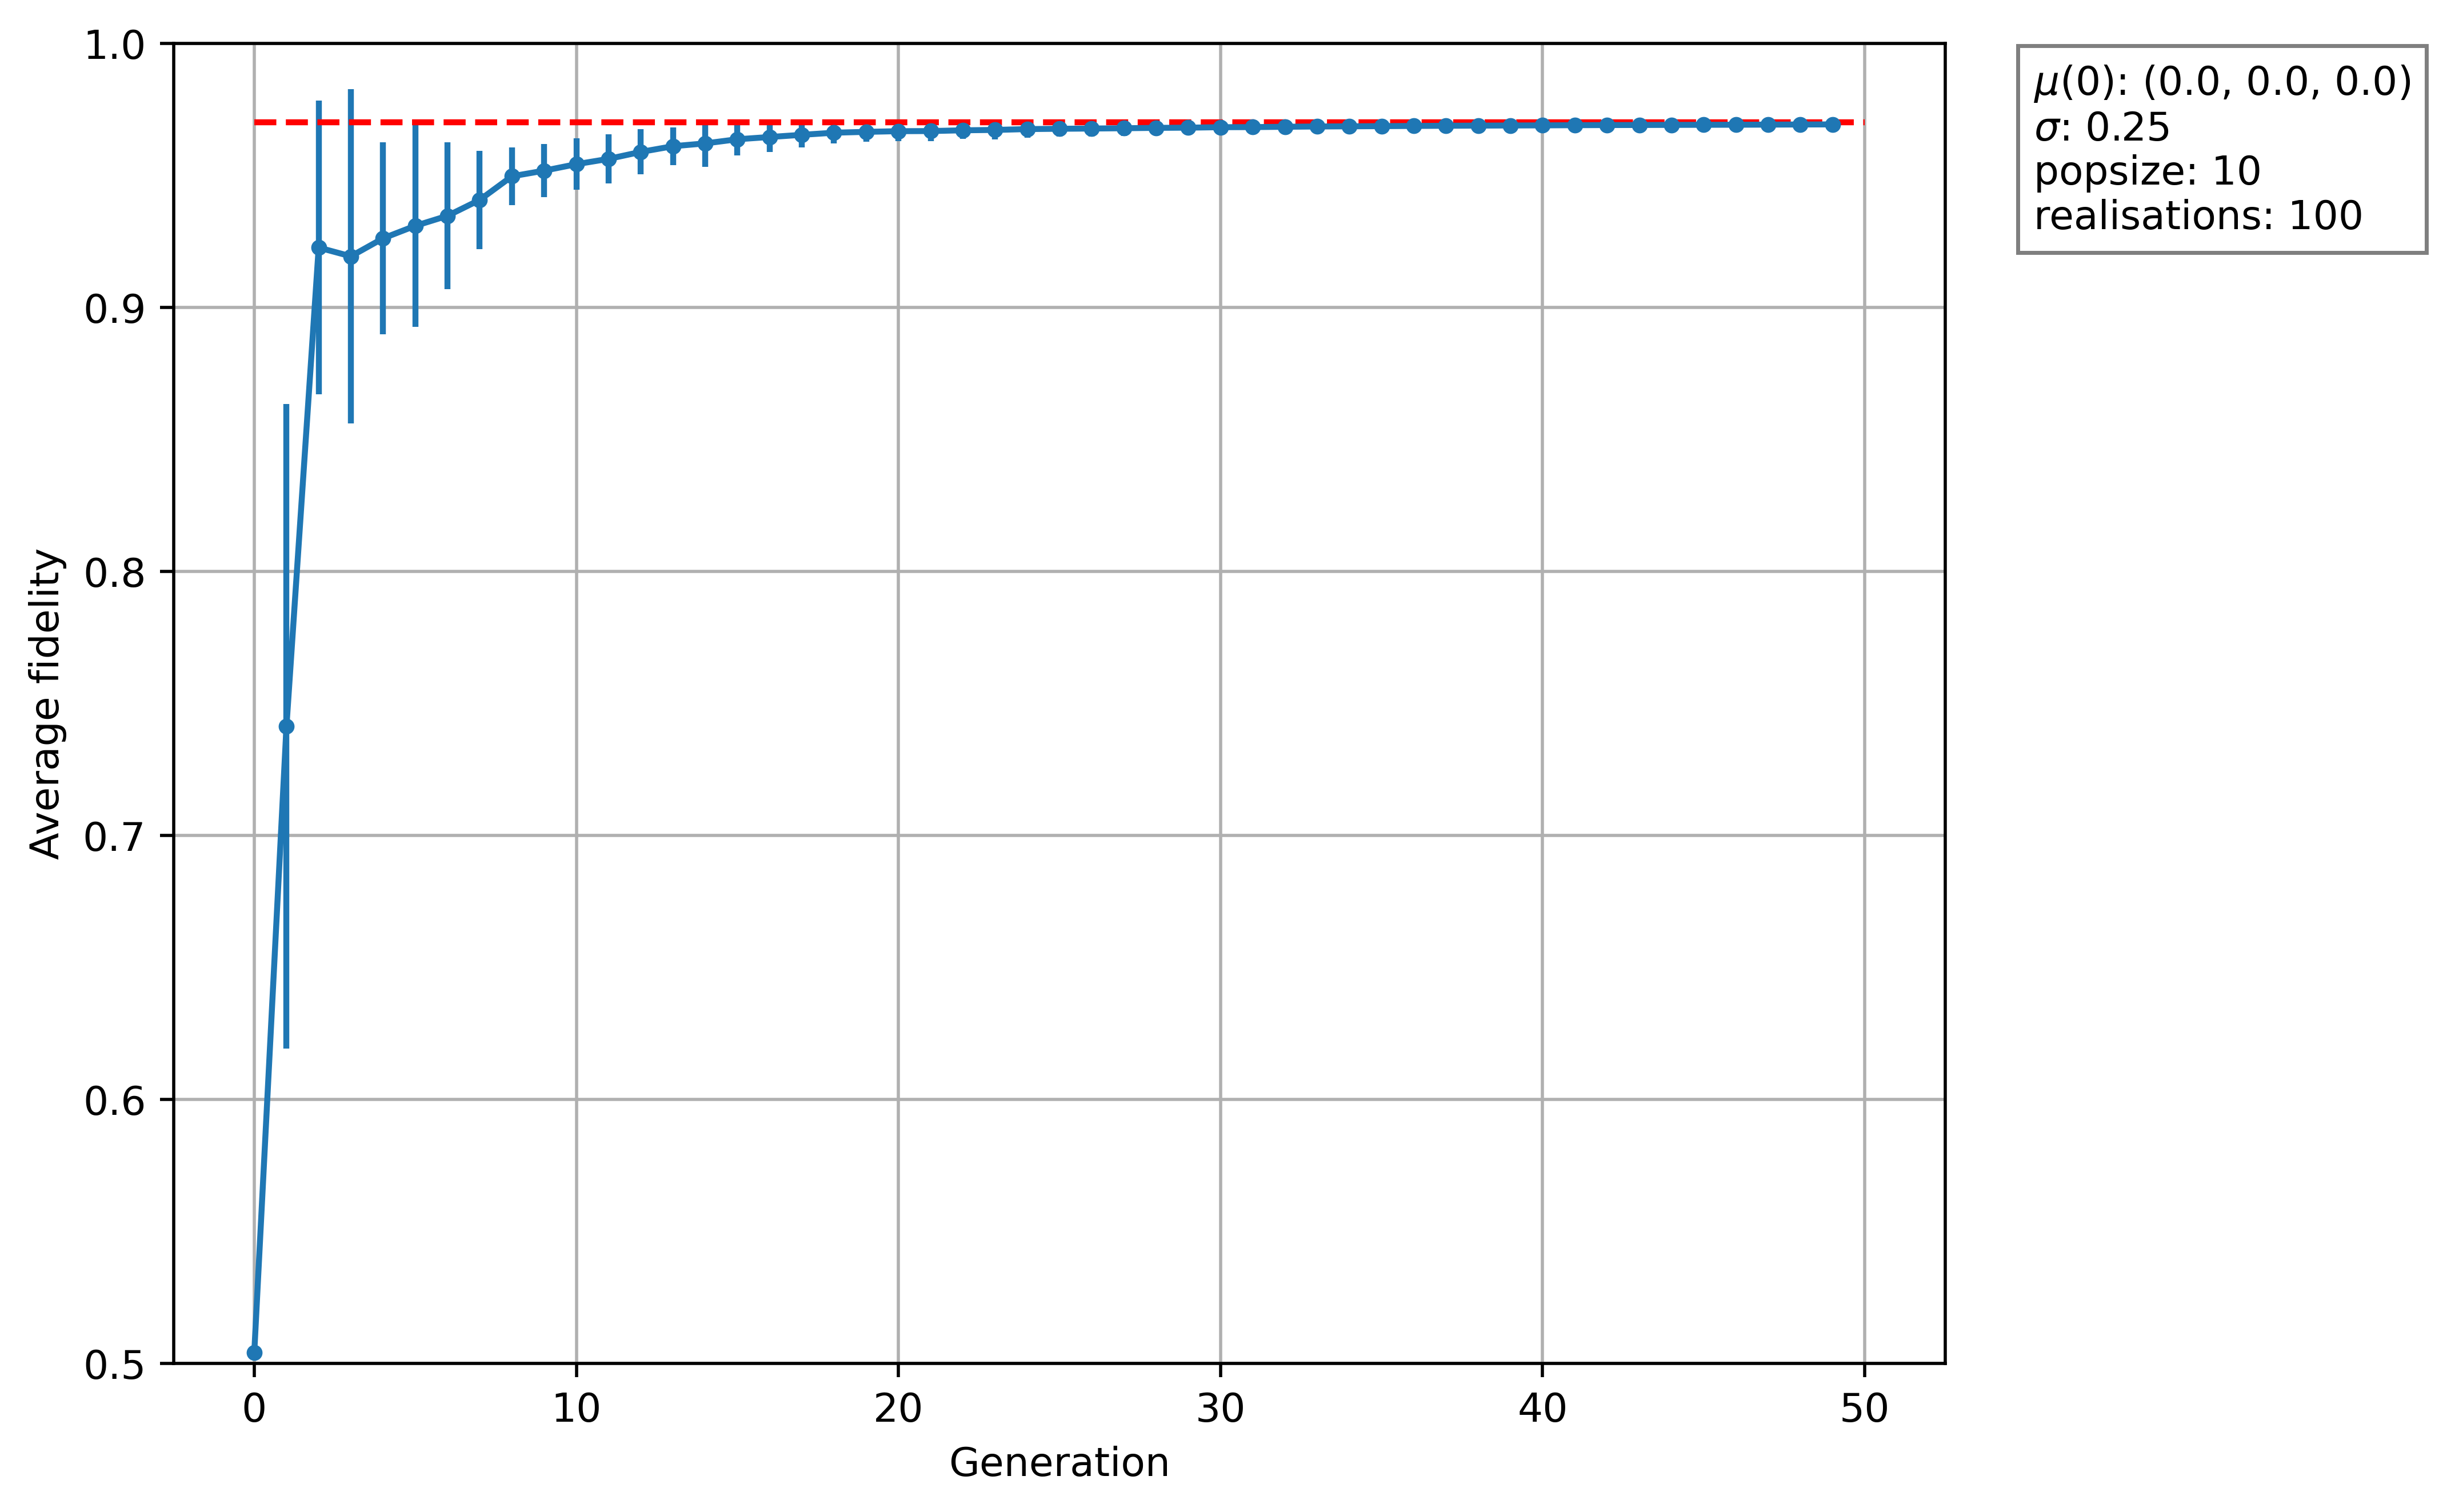

In [9]:
constants = {
    r"$\mu$(0)": tuple(float(row) for row in mean),
    r"$\sigma$": sigma,
    r"popsize": popsize,
    "realisations": Nreal,
}

plt.figure(figsize=(8, 6), dpi = 500)
plt.errorbar(range(Ngen), mean_fidelity_evolution,yerr=std_fidelity_evolution,fmt = "-o",ms=3)
plt.xlabel("Generation")
plt.ylabel("Average fidelity")
plt.hlines(max(QND_pi_fidelity), 0, Ngen, color='red', ls="--", label = "Max avarage assignment fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

plt.grid()
plt.ylim(0.5, 1)
plt.savefig("Same_initial_point_average_of_100_realisations_3D_QND_pi_fid.pdf")
plt.show()


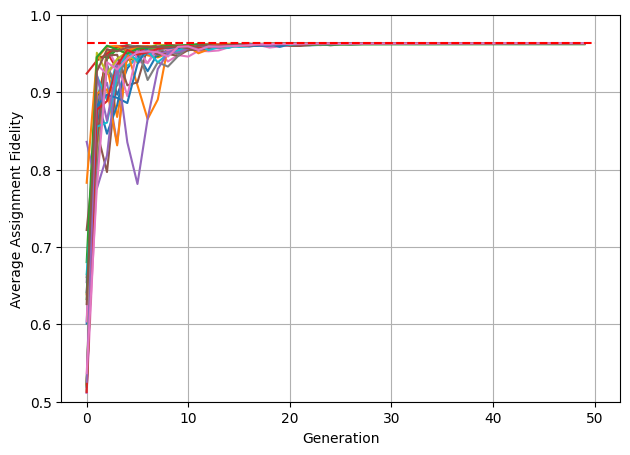

In [31]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data

x = np.linspace(0,1,3)
y = np.linspace(0,1,3) 
z = np.linspace(0,1,3)

combinations = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)

popsize = 10
sigma = 0.25
Ngen = 50
Nreal = 1

fidelity_different_mean = np.zeros((len(combinations),Ngen))
std_fidelity_different_mean = np.zeros((len(combinations),Ngen))

for i in range(len(combinations)):
    fidelity_evolution = np.zeros((Nreal,Ngen))
    
    for j in range(Nreal):
        fidelity_evolution[j,:] = cmaes_frequency_amplitude_and_duration(combinations[i], sigma, popsize, Ngen, frequency, amplitude, duration, average_fidelity)
        plt.plot(range(Ngen),fidelity_evolution[j,:])
        
    fidelity_different_mean[i,:] = np.mean(fidelity_evolution,axis=0)
    std_fidelity_different_mean[i,:] = np.std(fidelity_evolution,axis=0)

plt.xlabel("Generation")
plt.ylabel("Average Assignment Fidelity")
plt.ylim([0.5, 1])
plt.hlines(max(average_fidelity), 0, Ngen, color='red', linestyle="--", label="Max Avg Fidelity")
plt.grid()
# ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

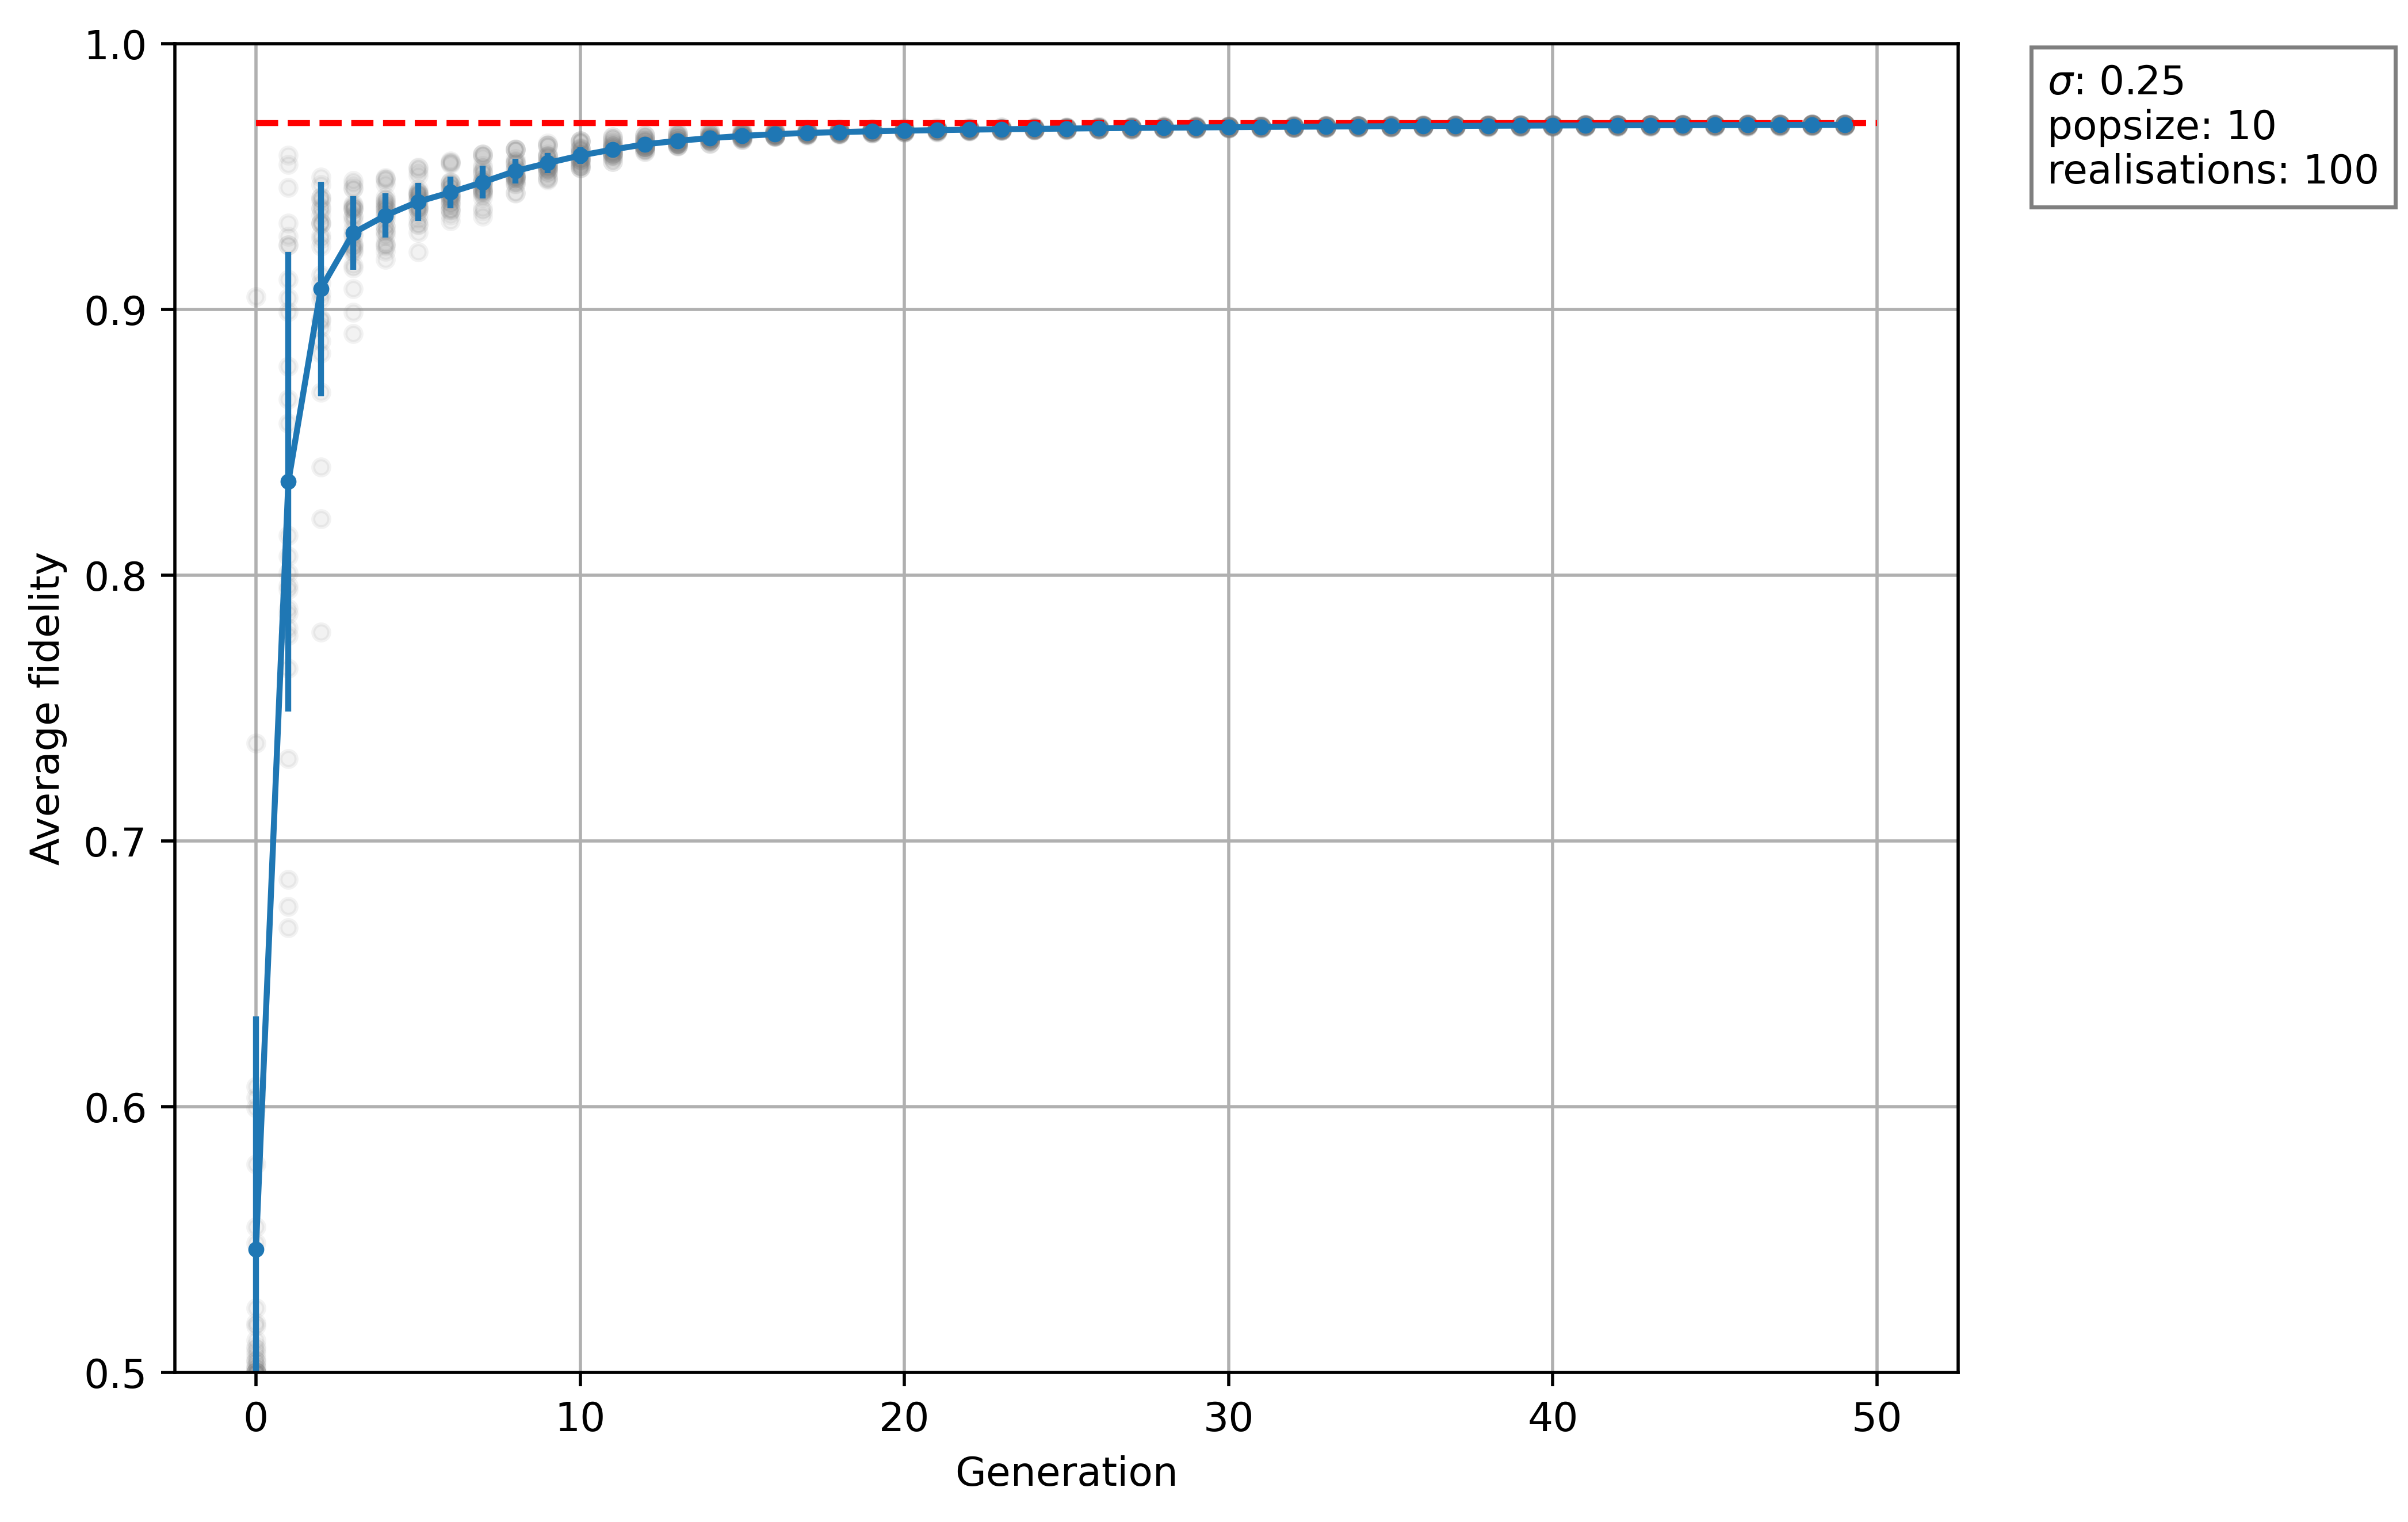

In [11]:
average_fidelity_different_mean = np.mean(fidelity_different_mean,axis=0)
std_fidelity_different_mean = np.std(fidelity_different_mean,axis=0)

Ngen = 50

constants = {
    # r"$\mu$(0)": tuple(float(row) for row in mean),
    r"$\sigma$": sigma,
    r"popsize": popsize,
    "realisations": Nreal,
}

plt.figure(figsize=(8, 6), dpi = 500)

for i in range(len(fidelity_different_mean)):
    plt.plot(range(Ngen),fidelity_different_mean[i,:],"o",ms=4,c = "gray", alpha = .1)

plt.errorbar(range(Ngen), average_fidelity_different_mean,yerr=std_fidelity_different_mean,fmt = "-o",ms=3)


plt.xlabel("Generation")
plt.ylabel("Average fidelity")
plt.hlines(max(QND_pi_fidelity), 0, Ngen, color='red', ls="--", label = "Max avarage assignment fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

plt.grid()
plt.ylim(0.5, 1)
plt.savefig("Different_initial_point_average_of_100_realisations_3D_QND_pi.pdf")
plt.show()

In [12]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data


popsizes = np.arange(2,32,2)

sigma = 0.25 #1/4 of the domain 
mean = np.array([0.0,0.0,0.0])
Ngen = 50
Nreal = 100

fidelity_different_popsize = np.zeros((len(popsizes),Ngen))
std_fidelity_different_popsize = np.zeros((len(popsizes),Ngen))

for i in range(len(popsizes)):
    fidelity_evolution = np.zeros((Nreal,Ngen))
    
    for j in range(Nreal):
        fidelity_evolution[j,:] = cmaes_frequency_amplitude_and_duration(mean, sigma, popsizes[i], Ngen, frequency, amplitude, duration, QND_pi_fidelity)
        
    fidelity_different_popsize[i,:] = np.mean(fidelity_evolution,axis=0)
    std_fidelity_different_popsize[i,:] = np.std(fidelity_evolution,axis=0)

/home/pschaefers/master/year2/MEP/lib/python3.10/site-packages/cmaes/_cma.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  1 + c1 / cmu,  # eq.50
/home/pschaefers/master/year2/MEP/lib/python3.10/site-packages/cmaes/_cma.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  (1 - c1 - cmu) / (n_dim * cmu),  # eq.52


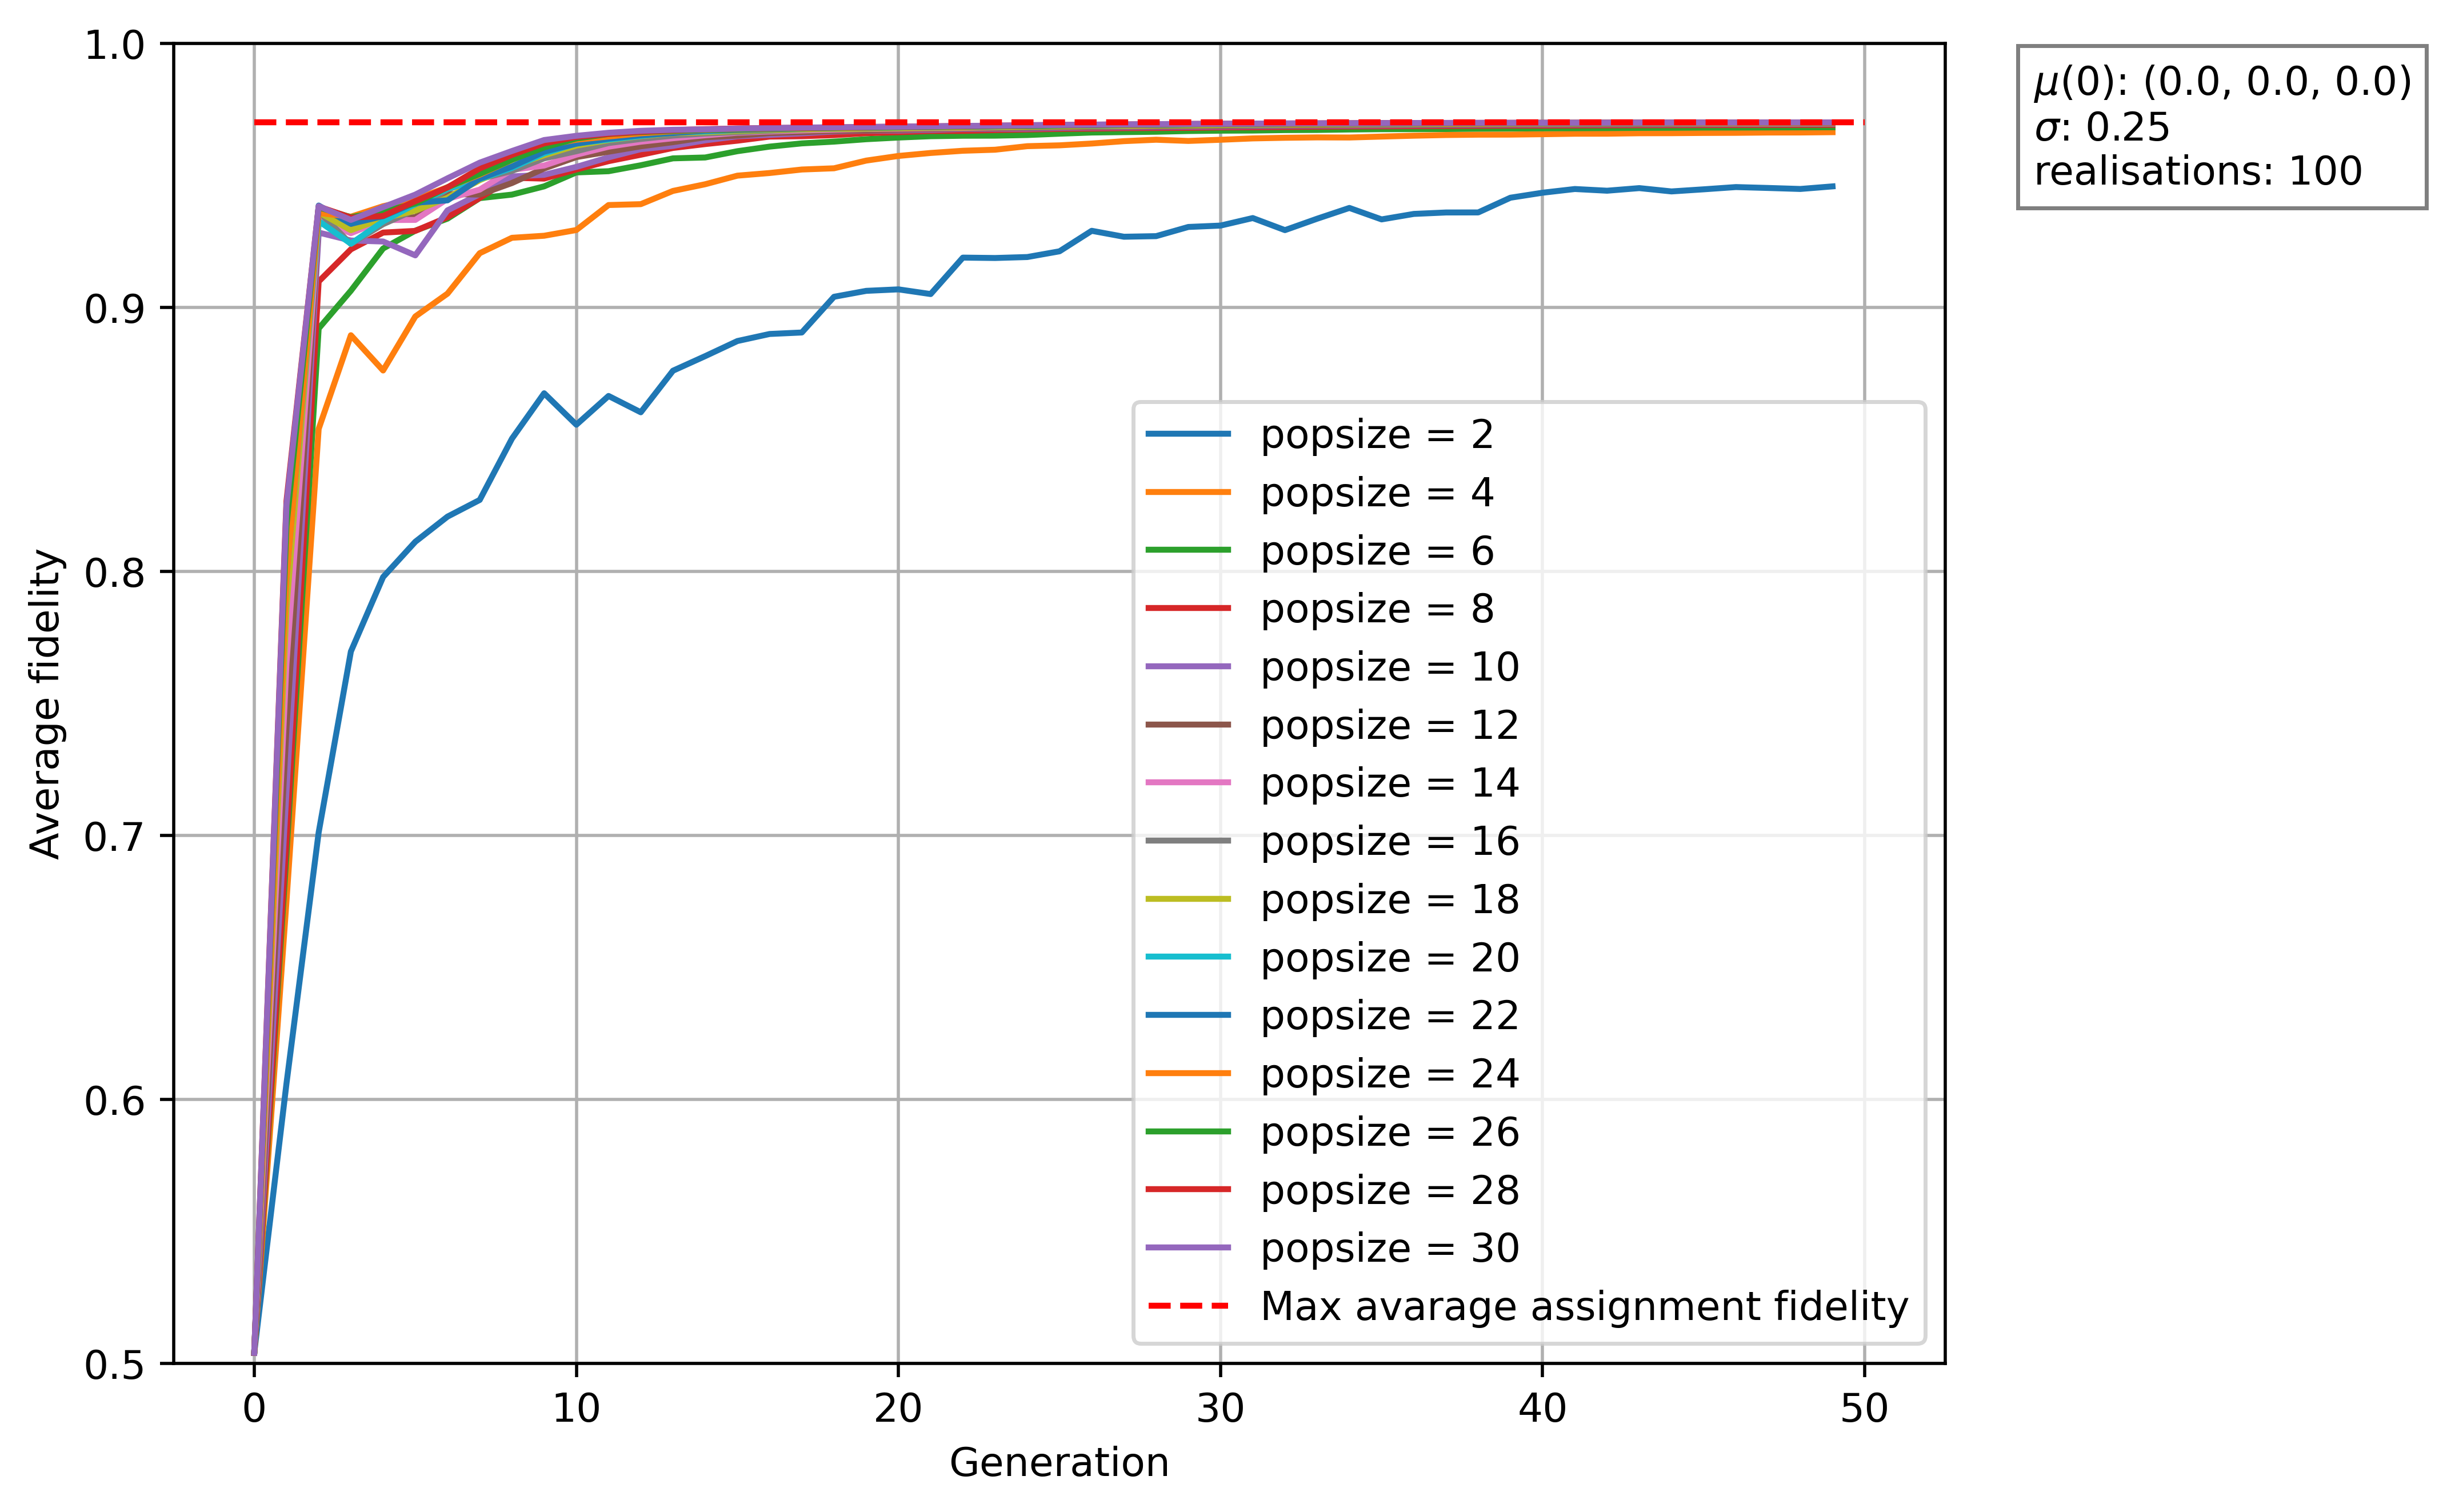

In [22]:
constants = {
    r"$\mu$(0)": tuple(float(row) for row in mean),
    r"$\sigma$": sigma,
    # r"popsize": popsize,
    "realisations": Nreal,
}

# print(len(popsizes))


plt.figure(figsize=(8, 6), dpi = 500)

for i in range(len(fidelity_different_popsize)):
    plt.plot(range(Ngen),fidelity_different_popsize[i,:],label = f"popsize = {popsizes[i]}")

# plt.errorbar(range(Ngen), average_fidelity_different_mean,yerr=std_fidelity_different_mean,fmt = "-o",ms=3)


plt.xlabel("Generation")
plt.ylabel("Average fidelity")
plt.hlines(max(QND_pi_fidelity), 0, Ngen, color='red', ls="--", label = "Max avarage assignment fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

# plt.xticks(popsizes)
plt.legend()
plt.grid()
plt.ylim(0.5, 1)
plt.savefig("Different_popsize_vs_Ngen_QND_pi.pdf")
plt.show()

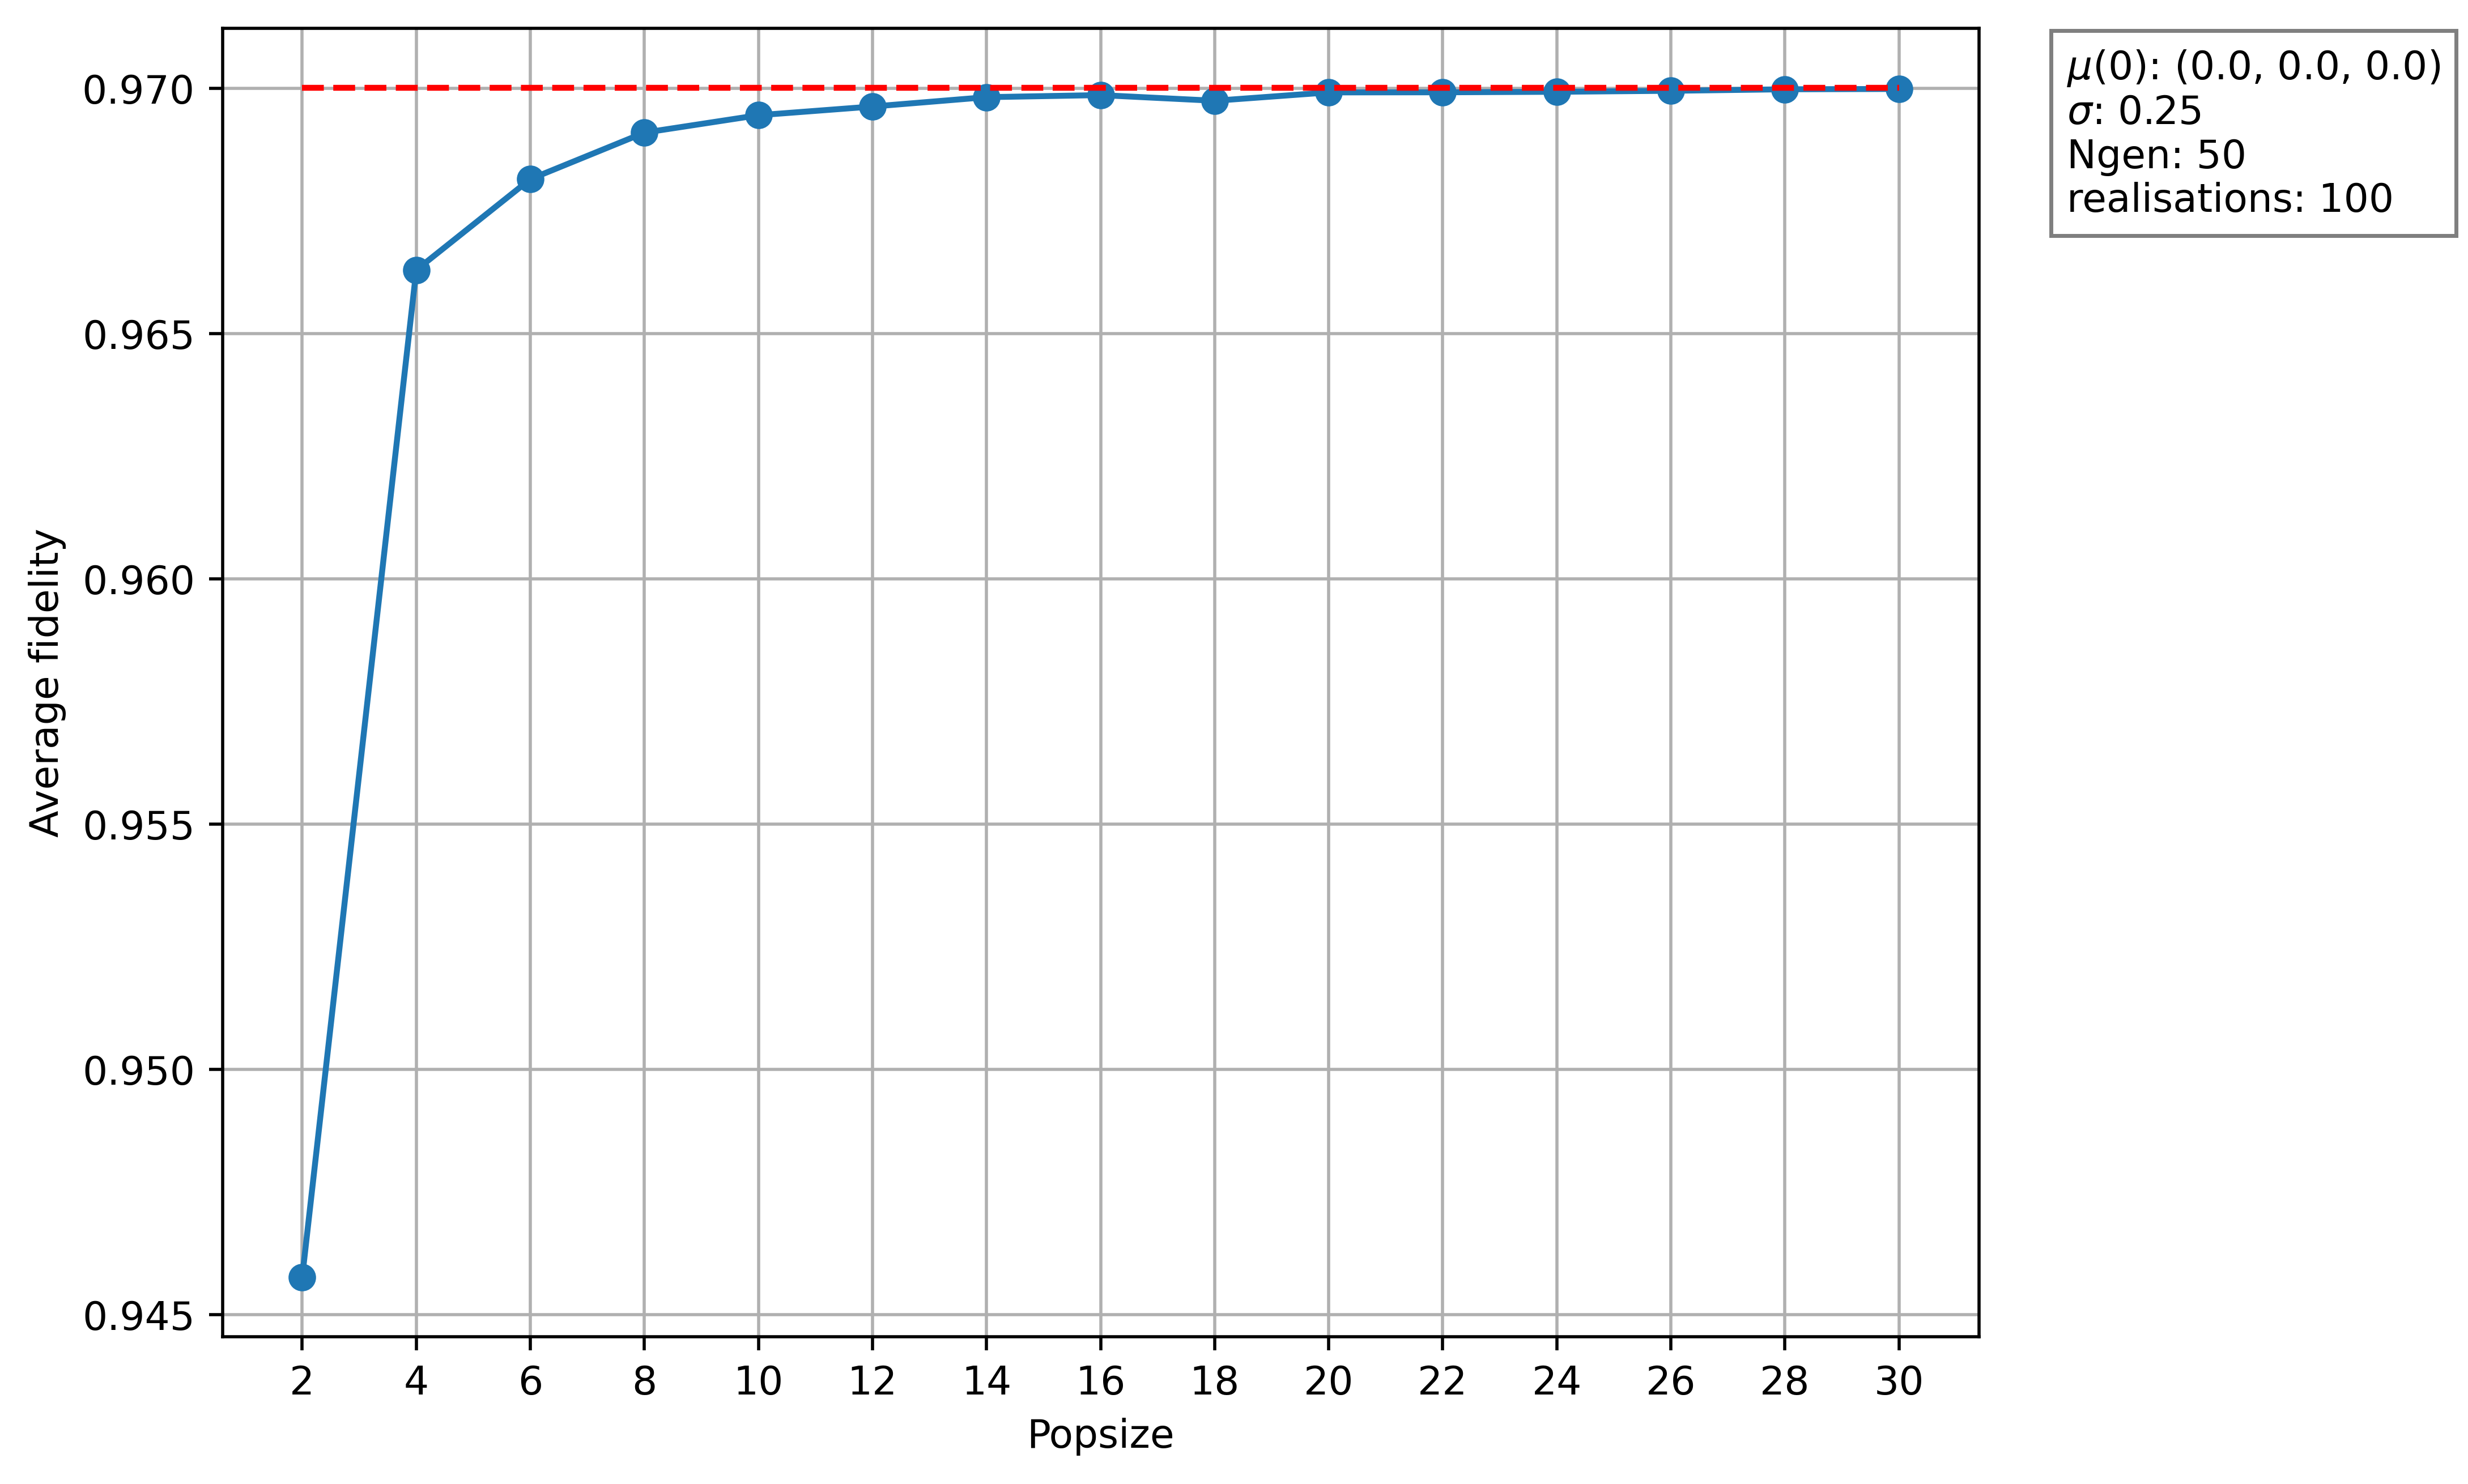

In [14]:
final_dif_pops = fidelity_different_popsize[:,-1]

constants = {
    r"$\mu$(0)": tuple(float(row) for row in mean),
    r"$\sigma$": sigma,
    "Ngen": Ngen,
    # r"popsize": popsize,
    "realisations": Nreal,
}

plt.figure(figsize=(8, 6), dpi = 500)
plt.plot(popsizes,final_dif_pops,"-o")
plt.grid()
plt.xlabel("Popsize")
plt.ylabel("Average fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

plt.hlines(max(QND_pi_fidelity), popsizes[0], popsizes[-1], color='red', ls="--")#, label = "Max avarage assignment fidelity")
plt.xticks(popsizes)
plt.savefig("Different_popsize_final_QND_pi.pdf")
plt.show()


In [15]:
#Import the data from measurements
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data
QND_pi_fidelity = dataset.y5.data


popsize = 20
sigmas = np.linspace(0.1,0.9,20) #1/4 of the domain 
mean = np.array([0.0,0.0,0.0])
Ngen = 50
Nreal = 100

fidelity_different_sigma = np.zeros((len(sigmas),Ngen))
std_fidelity_different_sigma = np.zeros((len(sigmas),Ngen))

for i in range(len(sigmas)):
    print(i)
    fidelity_evolution = np.zeros((Nreal,Ngen))
    
    for j in range(Nreal):
        fidelity_evolution[j,:] = cmaes_frequency_amplitude_and_duration(mean, sigmas[i], popsize, Ngen, frequency, amplitude, duration, QND_pi_fidelity)
        
    fidelity_different_sigma[i,:] = np.mean(fidelity_evolution,axis=0)
    std_fidelity_different_sigma[i,:] = np.std(fidelity_evolution,axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


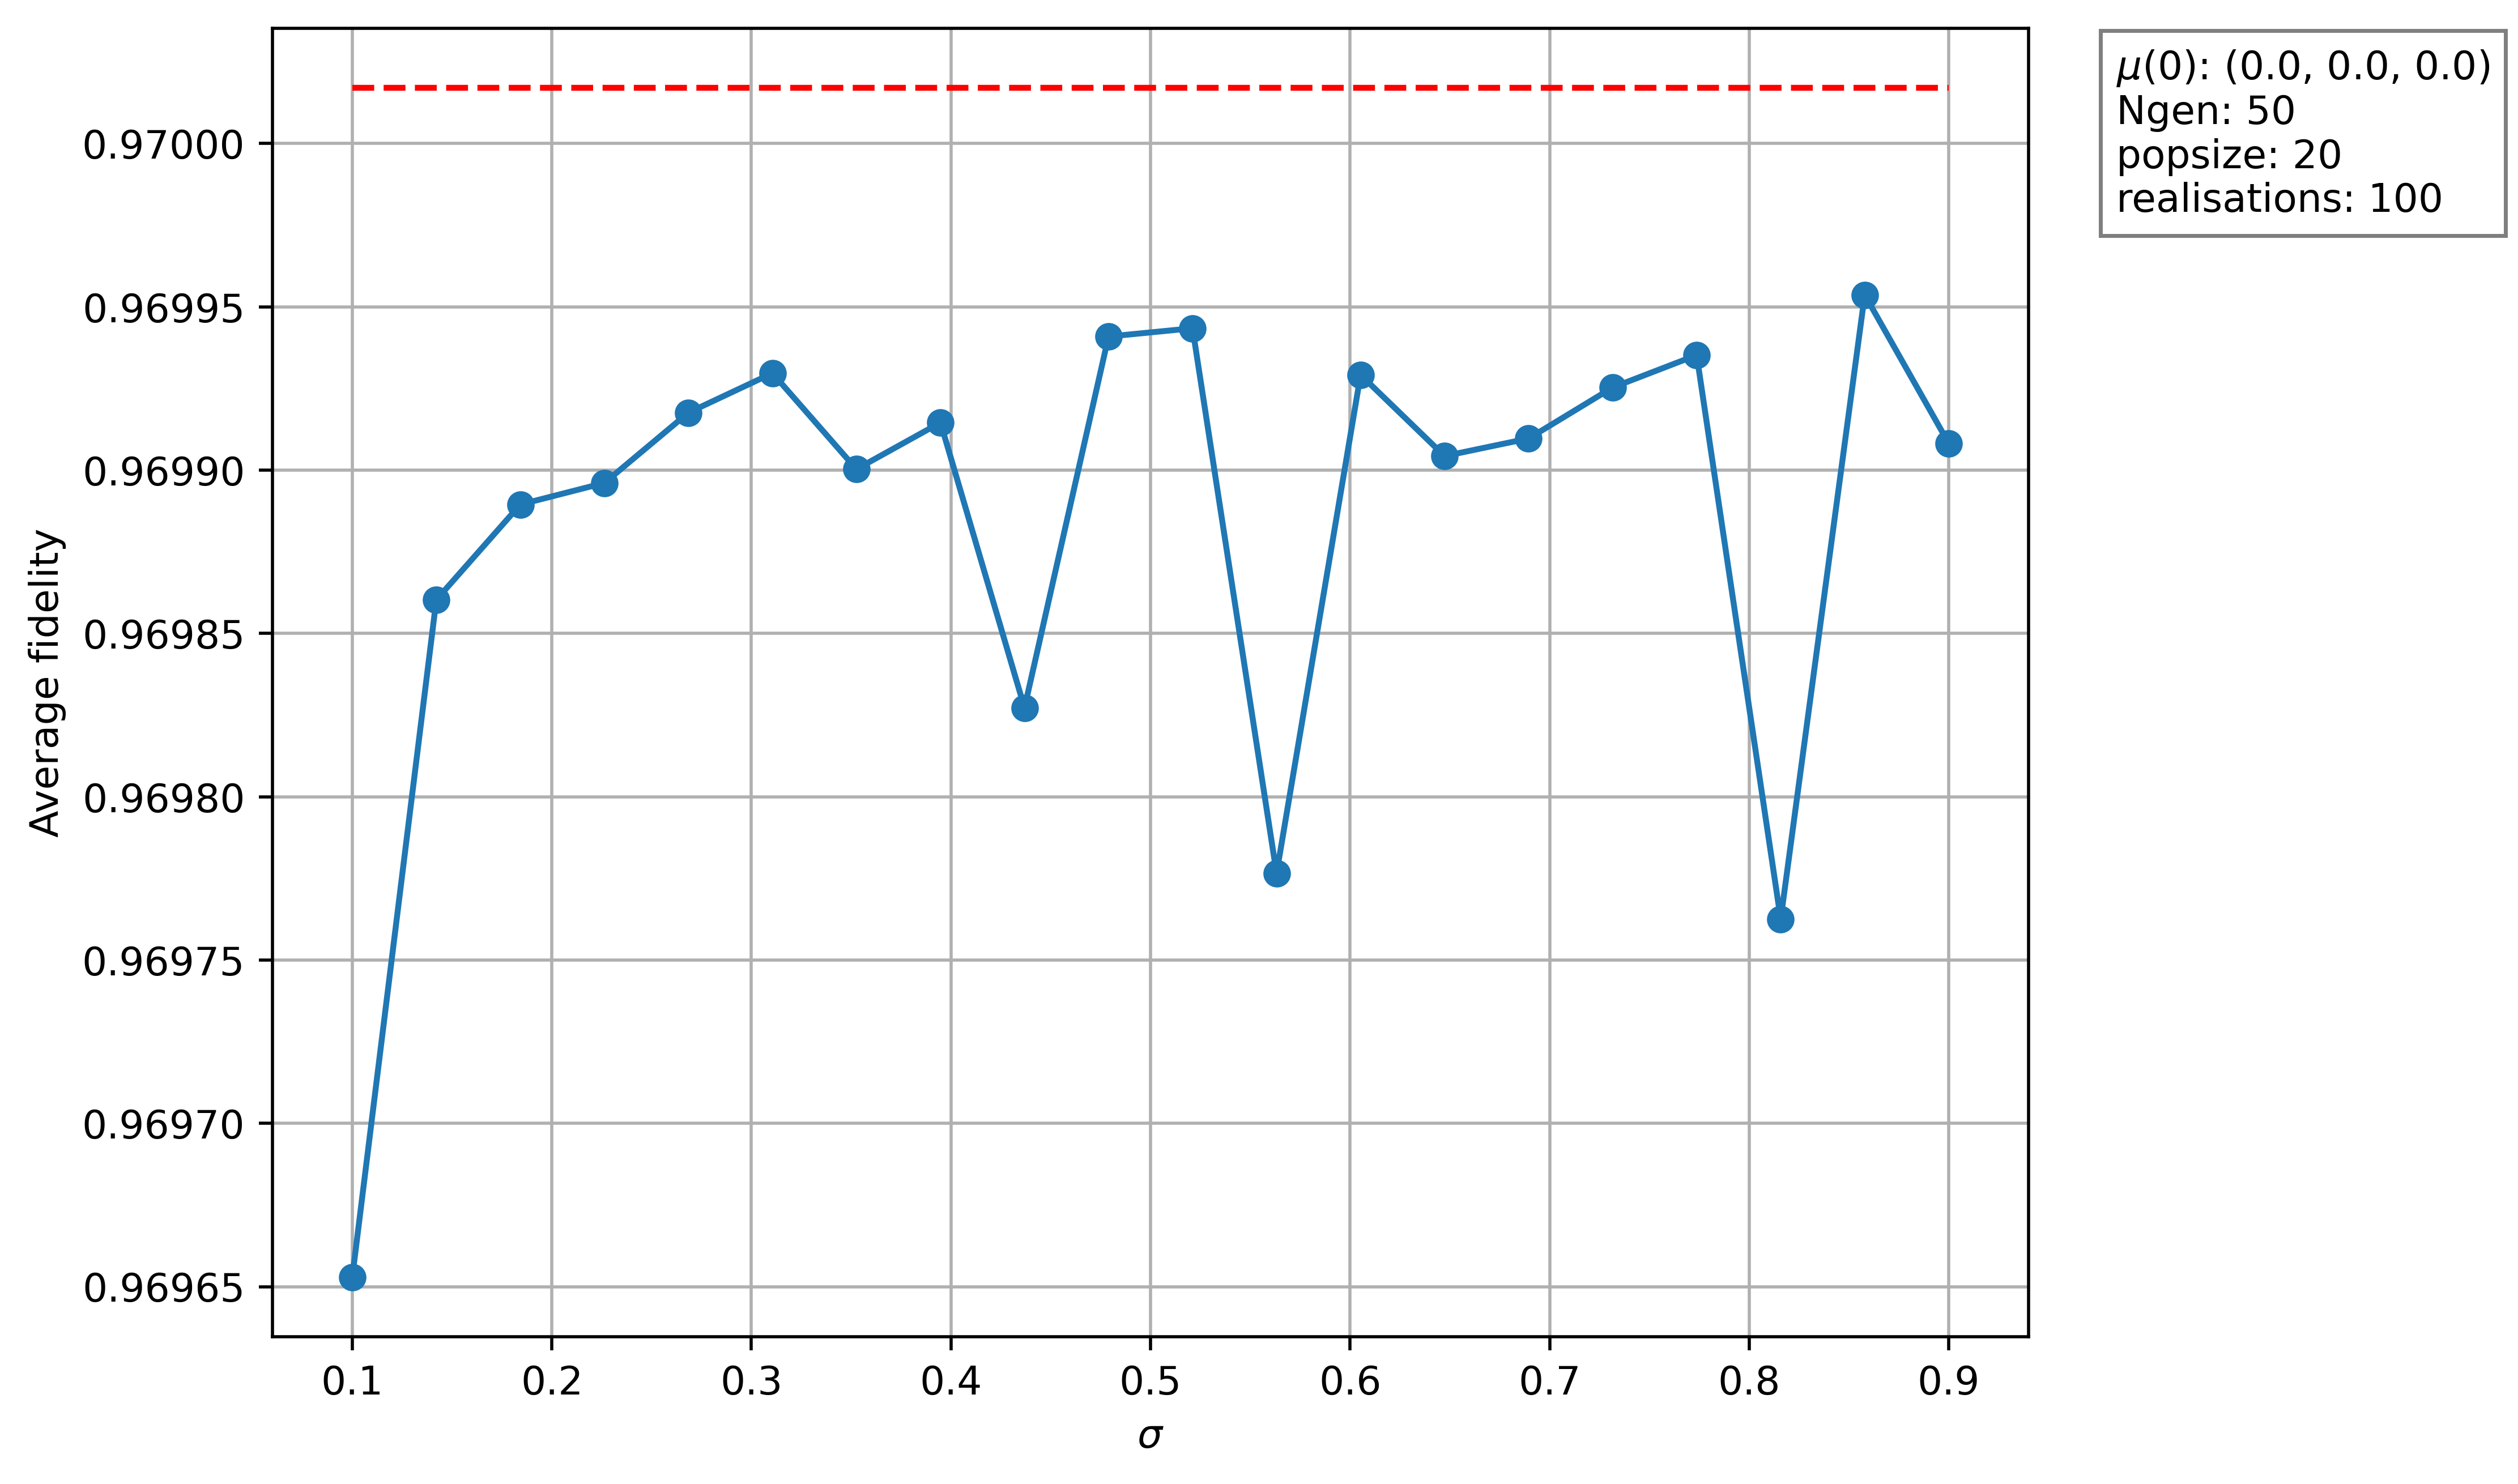

In [16]:
final_dif_sigs = fidelity_different_sigma[:,-1]

constants = {
    r"$\mu$(0)": tuple(float(row) for row in mean),
    # r"$\sigma$": sigma,
    "Ngen": Ngen,
    r"popsize": popsize,
    "realisations": Nreal,
}

plt.figure(figsize=(8, 6), dpi = 500)
plt.plot(sigmas,final_dif_sigs,"-o")
plt.grid()
plt.xlabel(r"$\sigma$")
plt.ylabel("Average fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

plt.hlines(max(QND_pi_fidelity), sigmas[0], sigmas[-1], color='red', ls="--")#, label = "Max avarage assignment fidelity")
# plt.xticks(sigmas)
plt.savefig("Different_sigma_final_QND_pi.pdf")
plt.show()

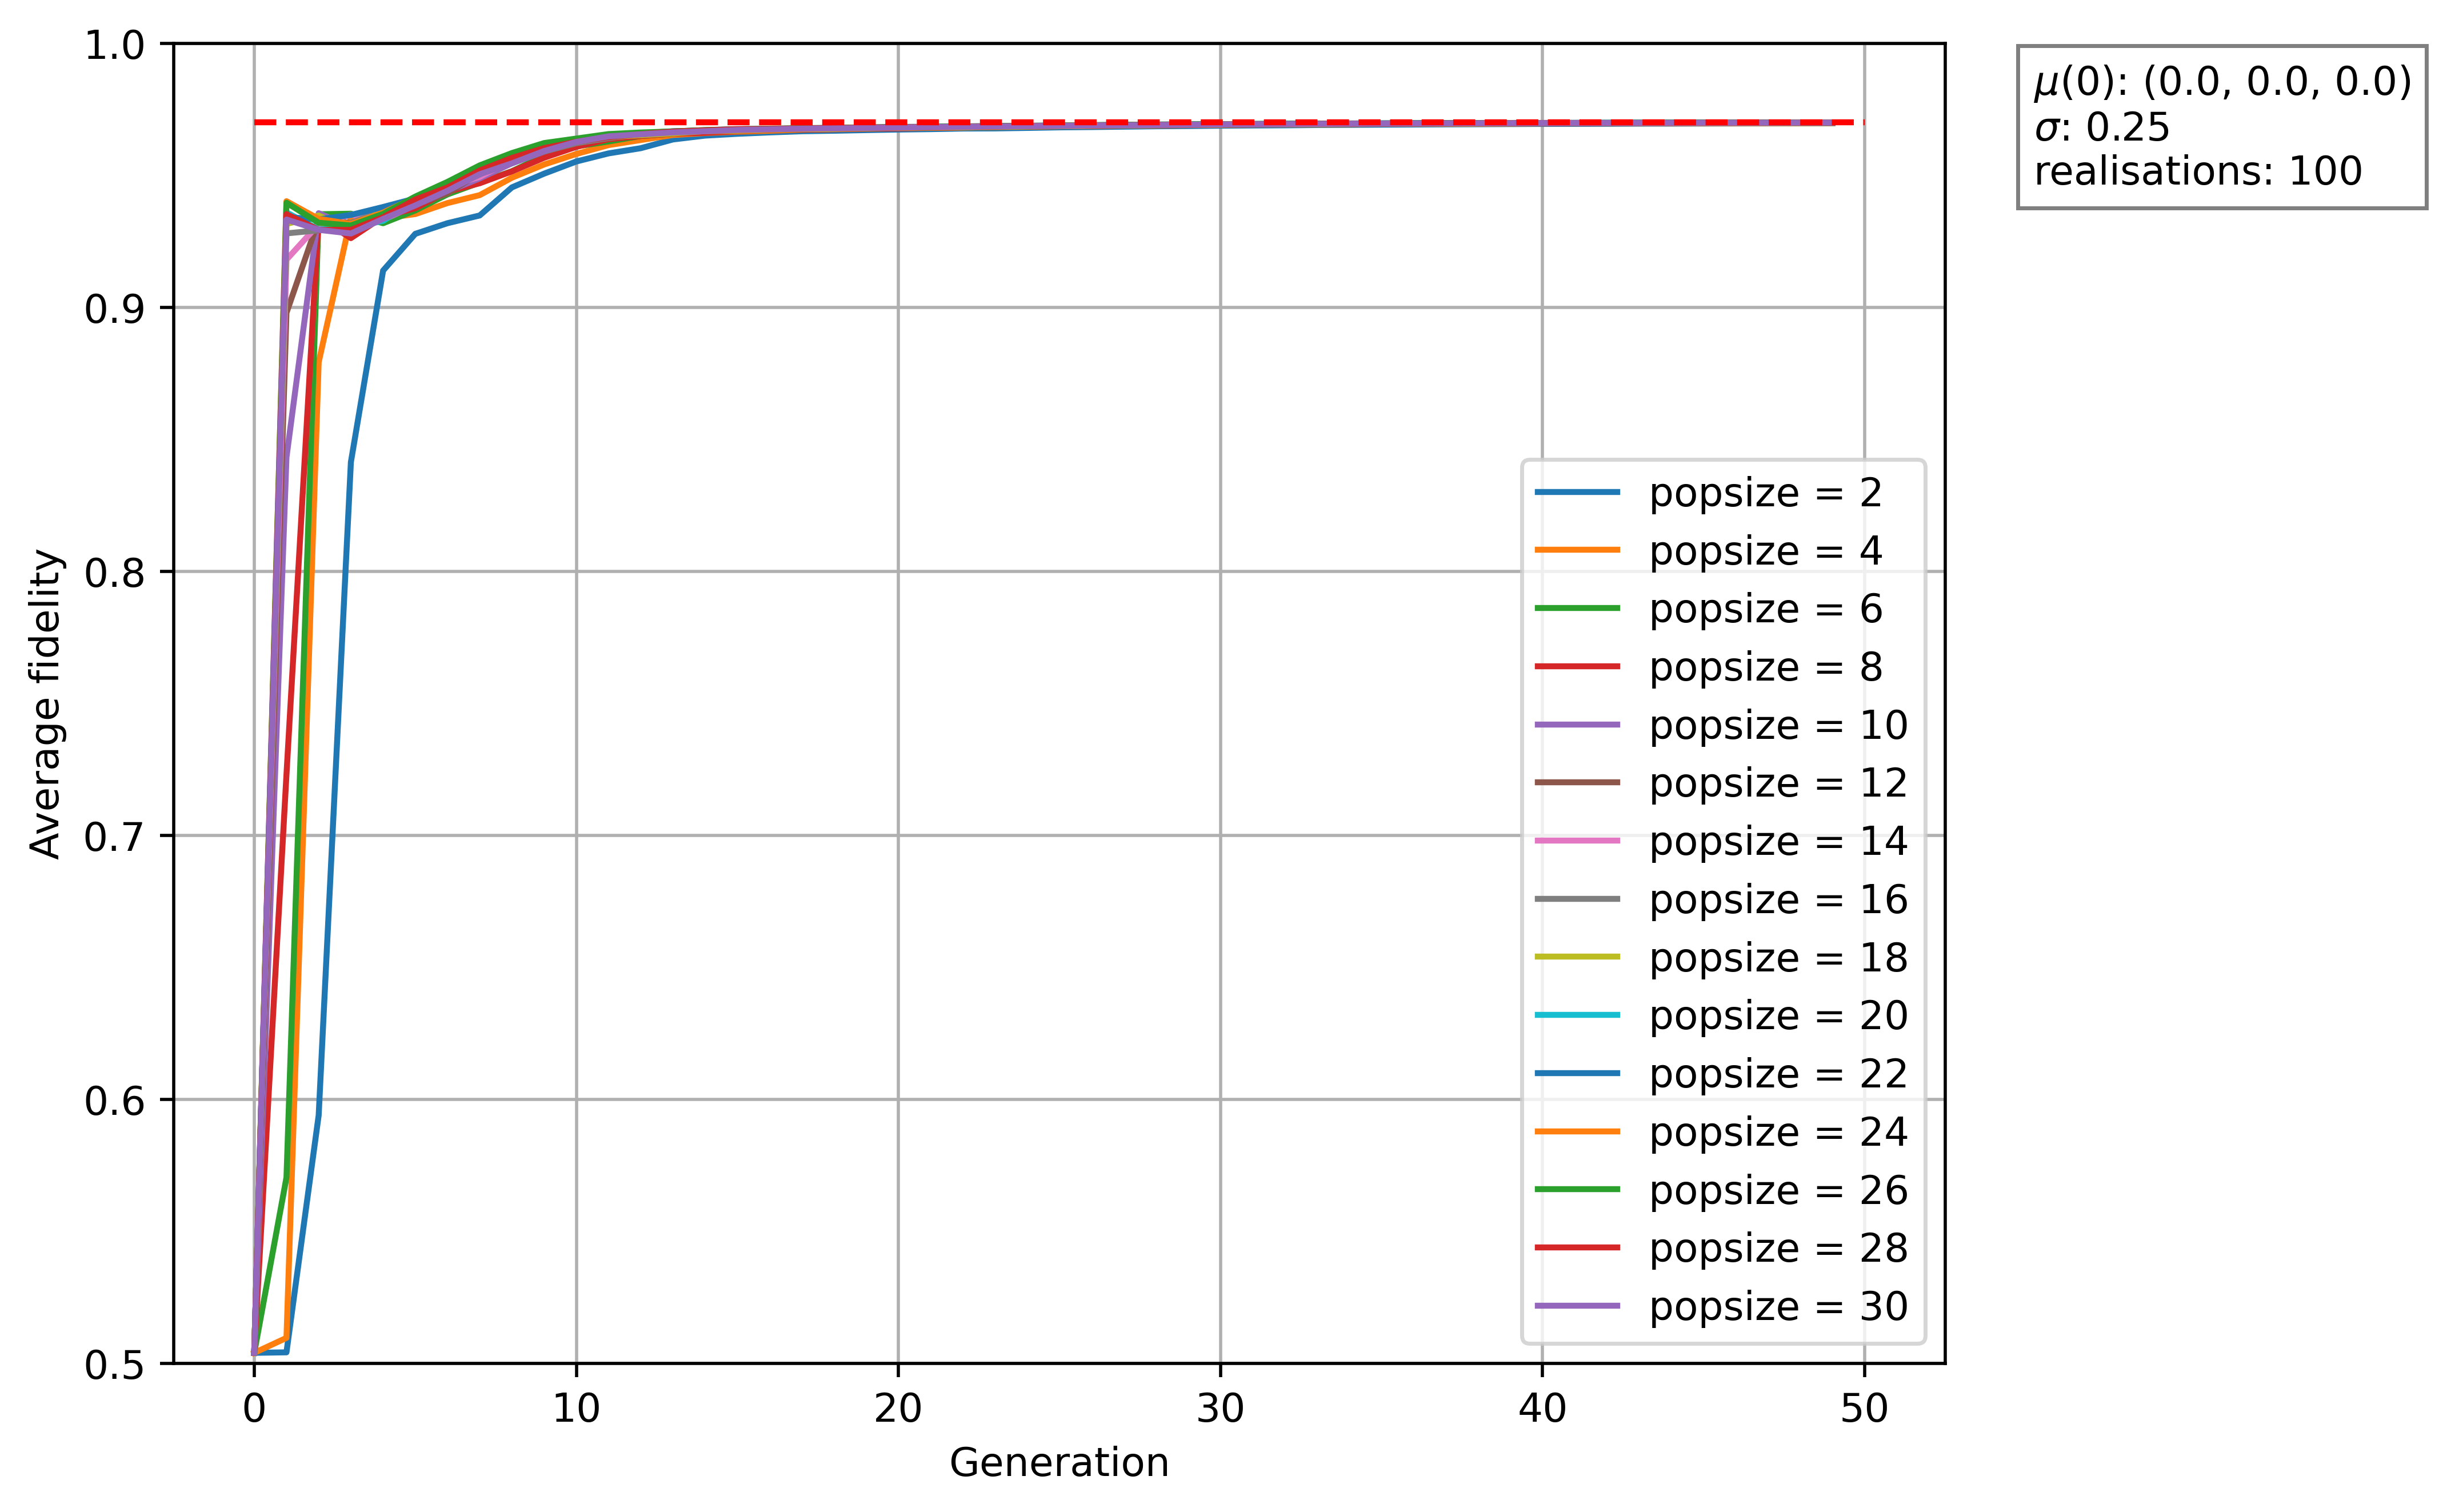

In [21]:
constants = {
    r"$\mu$(0)": tuple(float(row) for row in mean),
    r"$\sigma$": sigma,
    # r"popsize": popsize,
    "realisations": Nreal,
}



plt.figure(figsize=(8, 6), dpi = 500)

for i in range(len(fidelity_different_popsize)):
    plt.plot(range(Ngen),fidelity_different_sigma[i,:],label = f"popsize = {popsizes[i]}")

# plt.errorbar(range(Ngen), average_fidelity_different_mean,yerr=std_fidelity_different_mean,fmt = "-o",ms=3)


plt.xlabel("Generation")
plt.ylabel("Average fidelity")
plt.hlines(max(QND_pi_fidelity), 0, Ngen, color='red', ls="--")#, label = "Max avarage assignment fidelity")

# Format the constants into a string
constants_text = "\n".join([f"{key}: {value}" for key, value in constants.items()])

# Add the text box at the top-right, just outside the plot
plt.gca().text(
    1.05, 0.985,  # Position (x, y) in axes-relative coordinates
    constants_text,  # Text to display
    fontsize=10,  # Font size
    transform=plt.gca().transAxes,  # Use axes-relative positioning
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),  # Box style
    va = 'top'
)

# plt.xticks(range(Ngen))
plt.legend()
plt.grid()
plt.ylim(0.5, 1)
plt.savefig("Different_sigma_vs_Ngen_QND_pi.pdf")
plt.show()